In [19]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import networkx as nx
from collections import Counter
import scipy
from anytree import Node, RenderTree, LevelOrderGroupIter

from importlib import reload

# locals
import utils as ut
import plotting as plt2

In [2]:
# load the HWG
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/HWG/HWG.scanpy.h5ad"
hwg = sc.read_h5ad(fpath)
hwg

AnnData object with n_obs × n_vars = 18771 × 18771
    obs: 'gene_id', 'chrom', 'start', 'end', 'source', 'tf', 'mr', 'gene_class', 'is_scenic_tf', 'gene_biotype'
    var: 'gene_id', 'chrom', 'start', 'end', 'source', 'tf', 'mr', 'gene_class', 'is_scenic_tf', 'gene_biotype'
    uns: 'SCENIC+', 'TRRUST', 'eigenvalues', 'eigenvectors', 'master_regulators', 'n_eigenvalues', 'scenic_transcription_factors', 'transcription_factors', 'which_eigenvalues'

In [3]:
hwg.var_names[:10]

Index(['OR4F5', 'OR4F29', 'OR4F16', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1',
       'PERM1', 'HES4', 'ISG15'],
      dtype='object')

In [4]:
# compute quick summary stats
total_vals = hwg.X.sum()
sparsity = 100 - (hwg.X.sum() / hwg.X.todense().size) * 100
print(f"{total_vals=}")
print(f"{sparsity=:.3f}")

total_vals=1092721
sparsity=99.690


In [5]:
# how many TFs?
hwg.obs['tf'].value_counts()

tf
0    17170
1     1601
Name: count, dtype: int64

In [6]:
# how many TFs?
hwg.obs['mr'].value_counts()

mr
0    18086
1      685
Name: count, dtype: int64

In [7]:
def hwg_as_network(hwg):
    """Converts a hard-wired genome (`hwg`) into a NetworkX graph.

    Args:
        hwg: The hard-wired genome object.

    Returns:
        nx.Graph: The NetworkX graph representing the genome structure.
    """
    # 1. Direct Adjacency Conversion
    G = nx.from_pandas_adjacency(hwg.to_df())

    # 2. Simplified Attribute Update
    nx.set_node_attributes(G, hwg.obs.to_dict('index'))
    
    return G

G = hwg_as_network(hwg)
print(G)

Graph with 18771 nodes and 546703 edges


In [8]:
list(G.nodes)[:10]

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15']

In [9]:
[x for x in list(G.nodes) if "GATA2" in x]

['GATA2']

In [10]:
def get_interaction_tree(G, source, max_order):
    """Retrieves interactions from a source node within a specified maximum order.

    Args:
        G (nx.Graph): The NetworkX graph.
        source: The source node.
        max_order (int, optional): The maximum order (distance) from the source. Defaults to 1.

    Returns:
        pd.DataFrame: A DataFrame with columns 'step_0', 'step_1', ..., up to 'step_{max_order}',
                      containing nodes reached at each order.
    """
    paths = nx.single_source_shortest_path(G, source, cutoff=max_order).values()
    
    # Construct DataFrame with NaN Filling
    df = pd.DataFrame(paths).fillna("None")
    df.columns = [f"step_{i}" for i in range(len(df.columns))]
    return df
    
paths = get_interaction_tree(G, 
                             source='GATA2', 
                             max_order=3) 

print(f"{paths.shape=} ({paths.shape[0] / hwg.X.shape[0]:.4f})")
paths.head()

paths.shape=(16500, 4) (0.8790)


,step_0,step_1,step_2,step_3
0,GATA2,None,None,None
1,GATA2,HDAC1,None,None
2,GATA2,TAL1,None,None
3,GATA2,JUN,None,None
4,GATA2,GFI1,None,None


In [11]:
# Count first order targets
max_order = 1

tf_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
]

tfs = hwg.uns['transcription_factors']
mrs = hwg.uns['master_regulators']

res = []

for tf in tf_list:
    paths = get_interaction_tree(G, 
                         source=tf, 
                         max_order=max_order) 
    
    n_genes = paths['step_1'].nunique()
    n_tfs = np.isin(paths['step_1'].unique(), tfs).sum()
    n_mrs = np.isin(paths['step_1'].unique(), mrs).sum()
    
    row = {
        'TF' : tf,
        'First-Order Genes' : n_genes - 1,
        'First-Order TFs' : n_tfs,
        'First-Order MRs' : n_mrs,
    }
        
    res.append(row)

res = pd.DataFrame(res)
print(res.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
TF & First-Order Genes & First-Order TFs & First-Order MRs \\
\midrule
GATA2 & 74 & 41 & 21 \\
GFI1B & 20 & 9 & 5 \\
FOS & 306 & 79 & 54 \\
STAT5A & 194 & 32 & 25 \\
REL & 264 & 22 & 14 \\
\bottomrule
\end{tabular}



# iHSC Specific Genes

In [12]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names = adata.var['gene_name'].values
adata

AnnData object with n_obs × n_vars = 8574 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [13]:
# extract normalized expression
df = adata.to_df()
df.head()

,ATAD3B,SKI,PEX14,PLCH2,SPSB1,HES3,PLEKHM2,CA6,NMNAT1,CCDC27,...,TSPY4,TSPY9,KDM5D,RBMY1F,BPY2C,CDY2B,SRY,VCY,DAZ1,RBMY1E
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,0.0,0.926184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.926184,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.960013,0.0,0.0
AAACCCAAGTTGAAGT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.037502,0.000000,0.0,0.0,0.0,0.000000,1.866631,0.0,0.0
AAACCCAAGTTGTCGT,0.0,1.196788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,1.196788,1.196788,0.0,0.0
AAACCCACAGAAGCGT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.362332,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
AAACCCACAGGAGGTT,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.526588,0.526588,0.0,0.0,0.0,0.000000,1.124746,0.0,0.0


In [14]:
hwg.uns.keys()

dict_keys(['SCENIC+', 'TRRUST', 'eigenvalues', 'eigenvectors', 'master_regulators', 'n_eigenvalues', 'scenic_transcription_factors', 'transcription_factors', 'which_eigenvalues'])

In [15]:
tf_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
]


res = []

for tf in tf_list:
    paths = get_interaction_tree(G, 
                         source=tf, 
                         max_order=max_order) 
    
    first_order = paths['step_1'].unique()
    first_order = [x for x in first_order if x in df.columns]
    
    stats = ut.calculate_gene_expression_stats(df[first_order])
    stats = stats.reset_index(names='gene_name')
    stats['tf'] = tf
    
    stats['is_tf'] = stats['gene_name'].isin(hwg.uns['transcription_factors'])
    stats['is_mr'] = stats['gene_name'].isin(hwg.uns['master_regulators'])
    res.append(stats)
    
res = pd.concat(res)
res.head()

,gene_name,average_expression,median_expression,std_dev,num_nonzero_cells,percent_nonzero,tf,is_tf,is_mr
0,FSTL1,3.187863,3.672685,1.544555,7580,88.41,GATA2,False,False
1,NKX2-5,3.157575,3.247860,0.606887,8433,98.36,GATA2,True,False
2,ARHGAP35,2.829582,2.916644,0.578931,8406,98.04,GATA2,True,False
3,KLF1,1.407960,1.500470,0.772495,7300,85.14,GATA2,True,True
4,HDAC3,1.208329,1.312327,0.699341,7043,82.14,GATA2,False,False


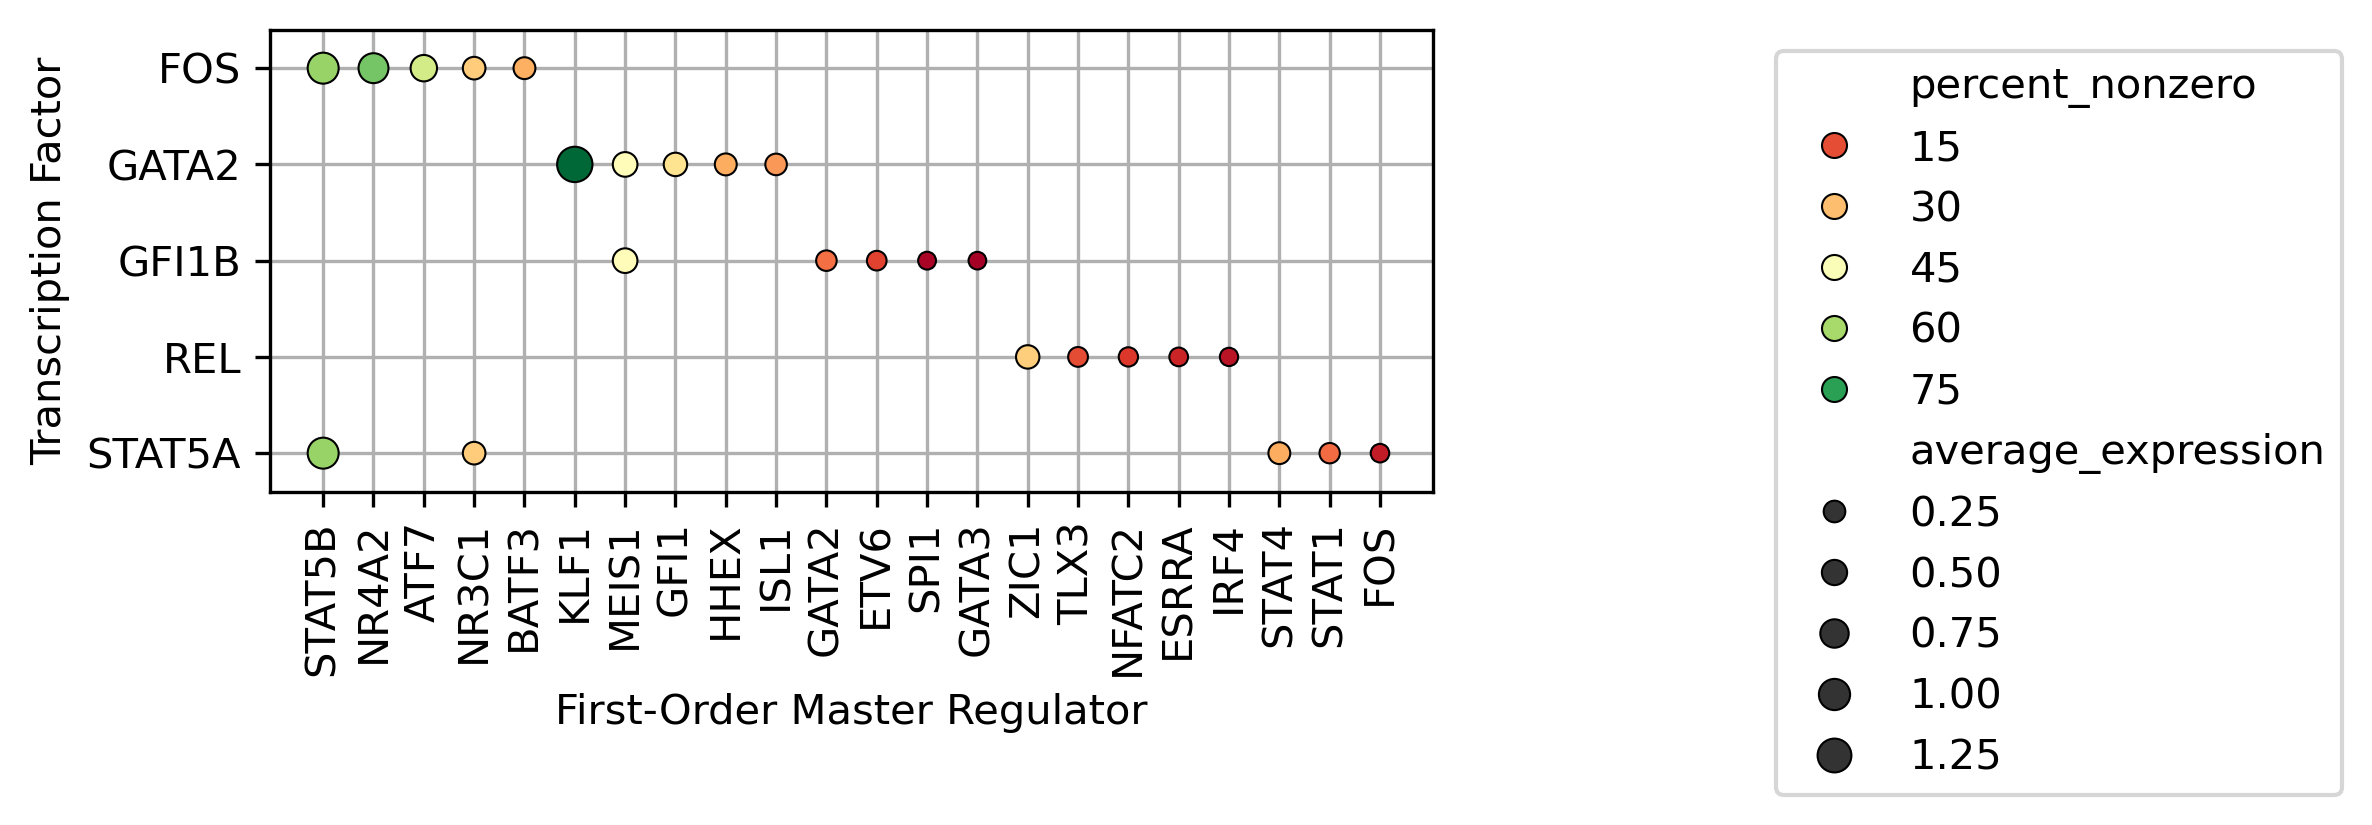

In [16]:
# table for highest expressed first order MRs in iHSC
n_top = 5
mask = res['is_mr']

table = []

for tf, group in res[mask].groupby('tf'):
    table.append(group.head(n_top))
    
table = pd.concat(table)



plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

sns.scatterplot(data=table,
                y='tf',
                x='gene_name',
                size='average_expression',
                hue='percent_nonzero',
                palette='RdYlGn',
                zorder=3,
                lw=0.5,
                ec='k')

plt.ylabel("Transcription Factor")
plt.xlabel("First-Order Master Regulator")
plt.gca().tick_params(axis='x', rotation=90)
plt.grid(True, zorder=0)

sns.move_legend(plt.gca(), 
                loc='upper right', 
                bbox_to_anchor=(1.8, 1))

plt.margins(y=0.1)

# table[['tf', 'gene_name', 'average_expression', 'percent_nonzero']]

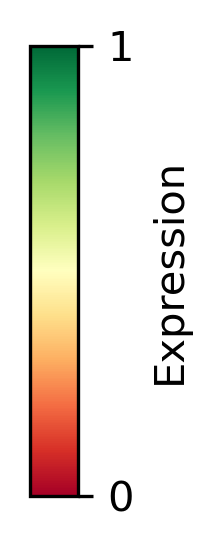

In [46]:
reload(plt2)
plt2.make_colorbar(cmap='RdYlGn', title='Expression')

# Network Plot

In [52]:
# generate the metadata frame
df = adata.to_df()
meta = ut.calculate_gene_expression_stats(df)
meta = meta.reset_index(names='gene_name')

meta = pd.merge(meta, hwg.obs, 
                how='left', left_on='gene_name',
                right_index=True
               )    


meta.head()

,gene_name,average_expression,median_expression,std_dev,num_nonzero_cells,percent_nonzero,gene_id,chrom,start,end,source,tf,mr,gene_class,is_scenic_tf,gene_biotype
0,CEACAM3,5.830416,5.987309,0.553027,8574,100.00,ENSG00000170956,19.0,41796587.0,41811554.0,HGNC Symbol,0.0,0.0,g3,0.0,protein_coding
1,MINDY1,4.918147,4.960259,0.597197,8562,99.86,ENSG00000143409,1.0,150996086.0,151008375.0,HGNC Symbol,0.0,0.0,g3,0.0,protein_coding
2,PSEN2,4.812243,4.864729,0.421894,8555,99.78,ENSG00000143801,1.0,226870184.0,226896105.0,HGNC Symbol,0.0,0.0,g3,0.0,protein_coding
3,ATG12,4.765070,4.936301,0.932989,8555,99.78,ENSG00000145782,5.0,115828200.0,115841837.0,HGNC Symbol,0.0,0.0,g3,0.0,protein_coding
4,TMEM168,4.730296,4.767966,0.414730,8551,99.73,ENSG00000146802,7.0,112762377.0,112790423.0,HGNC Symbol,0.0,0.0,g3,0.0,protein_coding


Full STAT5A network: DiGraph with 18272 nodes and 18271 edges
Thresholded STAT5A network: DiGraph with 14 nodes and 13 edges
['STAT5A', 'IL12RB1', 'IL5', 'JAK2', 'TBX15', 'ATP6V1E1', 'DTX2', 'BCL2L11', 'INS', 'EDNRB', 'ARFGAP2', 'PRR32', 'ATP6V1A', 'PCSK2']


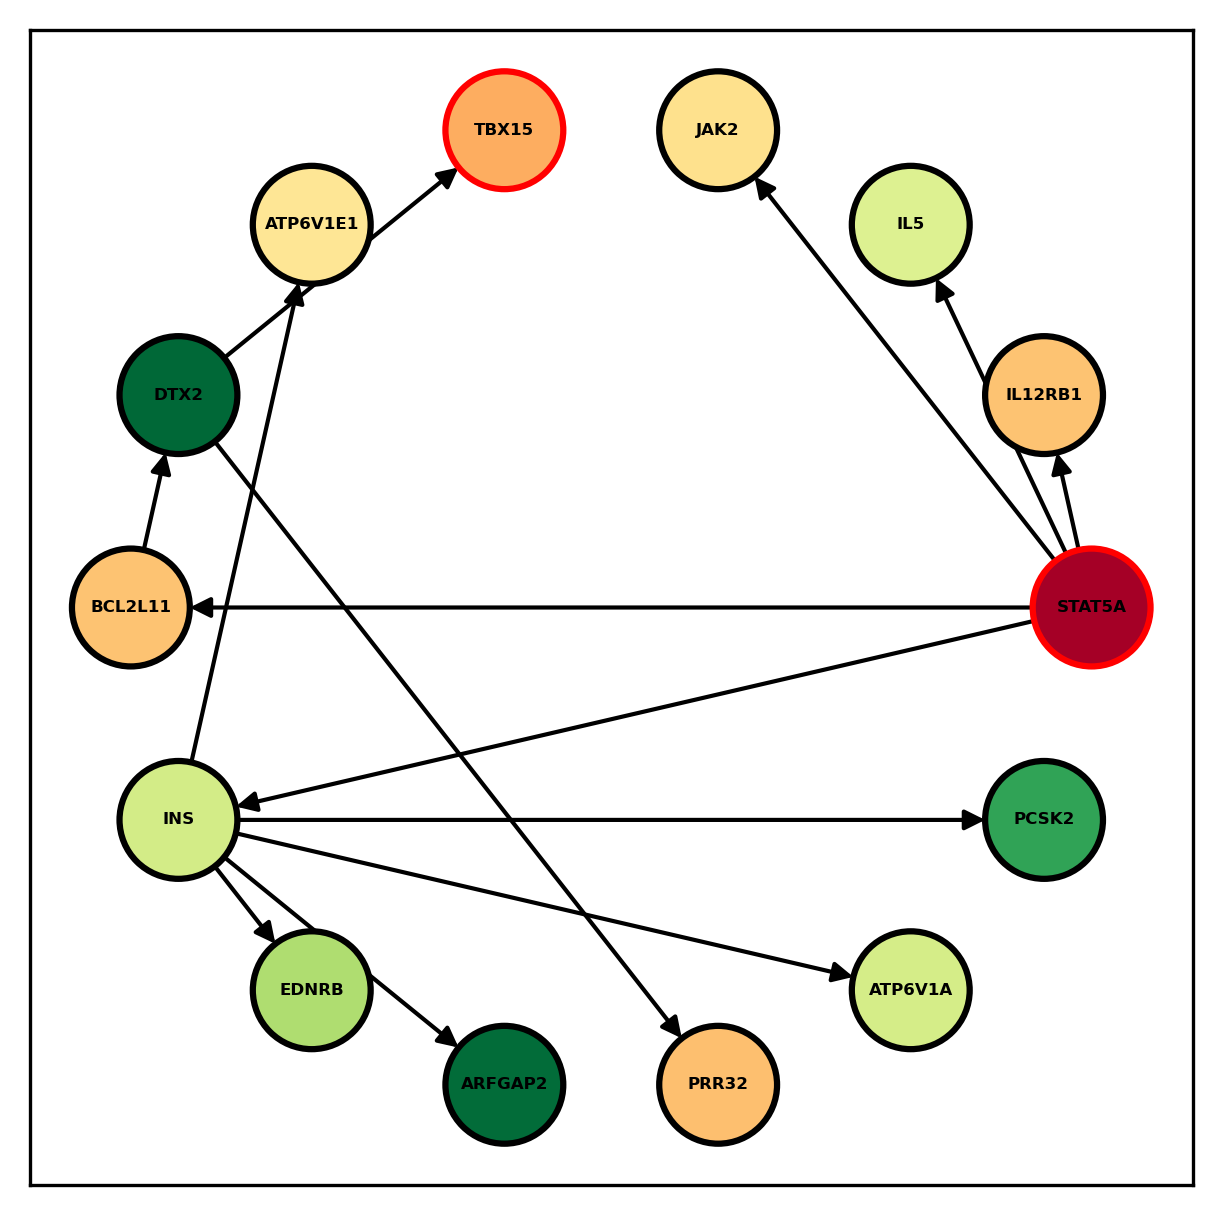

In [82]:
def make_source_target_network(G, source, max_order=3, metadata=None):
    """Creates a directed network from the HWG.

    Args:
        G: The input graph.
        source: The source node for finding paths.
        max_order: The maximum path length (default is 3).
        metadata (optional): Additional metadata for nodes/edges.

    Returns:
        pandas.DataFrame: A DataFrame with 'source' and 'target' columns representing the edges.
    """

    paths = nx.single_source_shortest_path(G, source, cutoff=max_order).values()
    pairs = [(u, v, i+1) for path in paths for i, (u, v) in enumerate(zip(path, path[1:])) if len(path) > 1]  # List comprehension
    pairs = pd.DataFrame(pairs, columns=['source', 'target', 'step'])
    
    G = nx.from_pandas_edgelist(
        pairs, source="source", target="target", 
        edge_attr="step", create_using=nx.DiGraph()
    )
    
    # Map gene expression data to the network nodes
    if not metadata is None:
        nx.set_node_attributes(G, metadata.set_index("gene_name").to_dict(orient="index"))
    
    return G



source = 'STAT5A'
threshold_column = 'average_expression'
threshold = 1.0
max_order = 4
H = make_source_target_network(G, 
                     source=source,
                     max_order=max_order,
                     metadata=meta)

# thresholding
nodes = meta[meta[threshold_column] > threshold]['gene_name'].to_list()
nodes.insert(0, source)
subgraph = H.subgraph(nodes).copy() 

# remove disconnected comps
connected_components = nx.weakly_connected_components(subgraph)
largest_component = max(connected_components, key=len)
subgraph = subgraph.subgraph(largest_component)


print(f"Full {source} network: {H}")
print(f"Thresholded {source} network: {subgraph}")
print(list(subgraph.nodes()))

# Node positions
# pos = nx.kamada_kawai_layout(subgraph)
# pos = nx.spring_layout(subgraph)
pos = nx.circular_layout(subgraph)

edges = list(subgraph.edges())

ecolors = ["r" if subgraph.nodes[n].get("tf", False) else "k" for n in subgraph.nodes]
colors = np.array([subgraph.nodes[n].get(threshold_column) for n in subgraph.nodes]) 
# edge_weights = 1 / np.array(list(nx.get_edge_attributes(subgraph, "step").values())) 

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

nx.draw_networkx(
    subgraph, 
    pos,
    ## nodes
    node_color=colors,
    node_shape='o',
    cmap='RdYlGn',
    alpha=1,
    edgecolors=ecolors, #color of node border
    node_size=800,
    linewidths=1.5, # width of node border
    with_labels=True,
    ## labels
    font_color='k',
    font_size=4,
    font_family='sans-serif', 
    font_weight='bold',
    horizontalalignment='center', 
    verticalalignment='center', 
    ## edges
    edgelist=edges,
    # width=edge_weights,
    edge_color='k',
    arrows=True,
    arrowsize=10
)


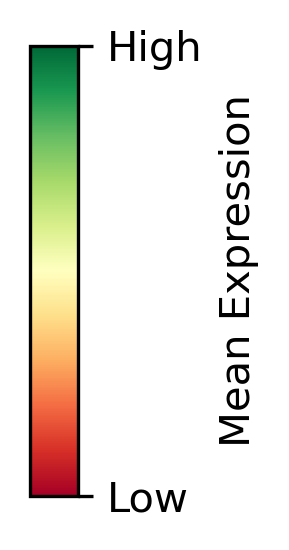

In [78]:
reload(plt2)
plt2.make_colorbar(cmap='RdYlGn', title='Mean Expression', tick_labels=['Low', 'High'])

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
?sns.move_legend

In [ ]:
# extract the HSC genes

mask = adata.obs['cell_type'] == 'HSC'
hsc = adata[mask, :].copy()
hsc = hsc.to_df(layer='log_norm')

hsc_genes = hsc.mean(axis=0).reset_index()
hsc_genes.columns = ['gene_name', 'mean_expression']
hsc_genes = hsc_genes.sort_values(by='mean_expression', ascending=False)

hsc_genes.head()

In [ ]:
break

In [ ]:
def get_path_counts(paths):
    """Analyzes path counts in a given data structure.

    Args:
        paths: The data structure containing paths (e.g., DataFrame, Series, list of lists).

    Returns:
        pd.DataFrame: A DataFrame containing genes sorted by count (descending),
                      with columns 'Gene', 'Count', and 'Percentage'.
    """
    # Flatten the paths into a single list and count occurrences
    counts = Counter(paths.values.ravel())
    total_count = sum(counts.values())

    # Create DataFrame
    pdf = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
    pdf.index.name = 'Gene'  # Name the index column 'Gene'
    pdf = pdf.reset_index()  # Move 'Gene' to a regular column
    
    # Calculate percentage
    pdf['Percentage'] = (pdf['Count'] / total_count) * 100
    
    # Sort by count (descending)
    pdf = pdf.sort_values(by='Count', ascending=False)
    
    return pdf

counts = get_path_counts(paths)
counts.head()

# TF FOI

In [ ]:
def label_matching_strings(df, string_list, label):
    """
    Replaces strings in a DataFrame that match items in a list with the original 
    string plus a provided label.

    Args:
        df (pd.DataFrame): The input DataFrame.
        string_list (list): List of strings to match.
        label (str): Label to append to matching strings.

    Returns:
        pd.DataFrame: Modified DataFrame with labeled strings.
    """

    # Create a copy of the DataFrame to avoid modifying the original
    modified_df = df.copy()

    # Get all string columns
    string_columns = modified_df.select_dtypes(include='object').columns

    for col in string_columns:
        # Replace matching strings in each string column
        modified_df[col] = modified_df[col].astype(str).str.replace(
            '|'.join(string_list),  # Create a regex pattern to match any string in the list
            lambda x: x.group() + label,  # Append label to matching strings
            regex=True  # Enable regex matching
        )

    return modified_df


paths = label_matching_strings(paths, hwg.uns['master_regulators'], " (MR)")
paths = label_matching_strings(paths, hwg.uns['transcription_factors'], " (TF)")
paths.head()

In [ ]:
tf_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
]

outdir = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/HWG/reprogramming_factors/"


for tf in tf_list:
    paths = get_interaction_tree(G, 
                         source=tf, 
                         max_order=3) 
    
    paths = label_matching_strings(paths, hwg.uns['master_regulators'], " (MR)")
    paths = label_matching_strings(paths, hwg.uns['transcription_factors'], " (TF)")
    
    outpath = f"{outdir}{tf}_hwg_interactions.csv"
    paths.to_csv(outpath, index=False)
    
print('Done')

In [ ]:
# Summary of paths

tf_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
]


tfs = hwg.uns['transcription_factors']
mrs = hwg.uns['master_regulators']

res = []

for tf in tf_list:
    paths = get_interaction_tree(G, 
                         source=tf, 
                         max_order=3) 
    
    row = {
        'tf' : tf,
    }
    
    for c in ['step_1', 'step_2', 'step_3']:
        vec = paths[c][paths[c].isin(mrs)]
        row[f'{c}'] = vec.nunique()
        
    res.append(row)
    
res = pd.DataFrame(res)
print(res.to_latex(index=False))

In [ ]:
# Summary of paths

tf_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',
]


tfs = hwg.uns['transcription_factors']
mrs = hwg.uns['master_regulators']

res = {}

n = 10

for tf in tf_list:
    paths = get_interaction_tree(G, 
                         source=tf, 
                         max_order=1) 
    
    
    paths = paths.rename(columns={'step_1' : tf})
    paths = paths[paths != 'None']
    paths = paths[tf].dropna()
    paths = paths[paths.isin(mrs)].sample(10).to_list()
    res[tf] = paths
    
    
    
    
    # break

#     res.append(paths)
    
    
res = pd.DataFrame(res)
res.head()

print(res.to_latex(index=False))

In [ ]:
", ".join(tf_list)

In [ ]:
hwg.uns['transcription_factors']

# HSC Specific Genes

In [ ]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/processed.anndata.lt.h5ad"

adata = sc.read_h5ad(fpath)
adata

In [ ]:
# extract the HSC genes

mask = adata.obs['cell_type'] == 'HSC'
hsc = adata[mask, :].copy()
hsc = hsc.to_df(layer='log_norm')

hsc_genes = hsc.mean(axis=0).reset_index()
hsc_genes.columns = ['gene_name', 'mean_expression']
hsc_genes = hsc_genes.sort_values(by='mean_expression', ascending=False)

hsc_genes.head()

In [ ]:
# Make the mask 
n_genes = 2000
genes = hsc_genes['gene_name'].head(n_genes).values

# filter out non-transcription factors
genes = [x for x in genes if x in hwg.uns['transcription_factors']]
print(len(genes))

H = G.subgraph(genes).copy() 
hsc_tf = nx.to_pandas_adjacency(H)

outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/HWG/hsc_tf_hwg.csv"
hsc_tf.to_csv(outpath)

hsc_tf.head()

In [ ]:
break

# Cell type specific data

In [ ]:
# load BJ data
df = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/R01/merged_fib_data.csv")
print(f"{df.shape=}")

df.head()

In [ ]:
n = 2000
col = 'chen_fibroblast_2015'

pdf = df.copy()
pdf = pdf[pdf['gene_name'].isin(hwg.var_names)]
pdf = pdf.set_index('gene_name')

pdf = pdf.sort_values(by=col, ascending=False)

genes = pdf.head(n).index
print(len(genes))

# Network Plot

In [ ]:
def make_source_target_network(G, source, max_order=3, metadata=None):
    """Creates a directed network from the HWG.

    Args:
        G: The input graph.
        source: The source node for finding paths.
        max_order: The maximum path length (default is 3).
        metadata (optional): Additional metadata for nodes/edges.

    Returns:
        pandas.DataFrame: A DataFrame with 'source' and 'target' columns representing the edges.
    """

    paths = nx.single_source_shortest_path(G, source, cutoff=max_order).values()
    pairs = [(u, v, i+1) for path in paths for i, (u, v) in enumerate(zip(path, path[1:])) if len(path) > 1]  # List comprehension
    pairs = pd.DataFrame(pairs, columns=['source', 'target', 'step'])
    
    G = nx.from_pandas_edgelist(
        pairs, source="source", target="target", 
        edge_attr="step", create_using=nx.DiGraph()
    )
    
    # Map gene expression data to the network nodes
    if not metadata is None:
        nx.set_node_attributes(G, metadata.set_index("gene_name").to_dict(orient="index"))
    
    return G



source = 'GATA2'
expression_column = "chen_fibroblast_2015"
expression_value = 3.5

meta = pd.merge(df, hwg.obs, 
                how='left', left_on='gene_name',
                right_index=True
               )    

H = make_source_target_network(G, 
                     source=source,
                     max_order=3,
                     metadata=meta)


nodes = meta[meta[expression_column] > expression_value]['gene_name'].to_list()
nodes.insert(0, source)

subgraph = H.subgraph(nodes).copy() 

# remove disconnected comps
connected_components = nx.weakly_connected_components(subgraph)
largest_component = max(connected_components, key=len)
subgraph = subgraph.subgraph(largest_component)

# Node positions
# pos = nx.kamada_kawai_layout(subgraph)
# pos = nx.spring_layout(subgraph)
pos = nx.circular_layout(subgraph)
# pos = nx.shell_layout(subgraph)

edges = list(subgraph.edges())

ecolors = ["r" if subgraph.nodes[n].get("transcription_factor", False) else "k" for n in subgraph.nodes]
colors = np.array([subgraph.nodes[n].get(expression_column) for n in subgraph.nodes]) 
edge_weights = 1 / np.array(list(nx.get_edge_attributes(subgraph, "step").values())) 

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10

nx.draw_networkx(
    subgraph, 
    pos,
    ## nodes
    node_color=colors,
    node_shape='o',
    cmap='RdYlGn',
    alpha=1,
    edgecolors=ecolors, #color of node border
    node_size=600,
    linewidths=1.5, # width of node border
    with_labels=True,
    ## labels
    font_color='k',
    font_size=4,
    font_family='sans-serif', 
    font_weight='bold',
    horizontalalignment='center', 
    verticalalignment='center', 
    ## edges
    edgelist=edges,
    width=edge_weights,
    edge_color='k',
    arrows=True,
    arrowsize=10
)


# TRRUST

In [ ]:
# add regulator information
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/TRRUST/trrust_rawdata.human.tsv"
rdf = pd.read_csv(fpath, sep="\t", header=None)
rdf.columns = ['source', 'target', 'class', 'evidence']
print(f"{rdf.shape=}")

class_map = {
    'Unknown' : 0, 
    'Activation' : 1,
    'Repression' : -1,
}

rdf['type'] = rdf['class'].map(class_map)

print(f"{rdf['source'].nunique()=}")
print(f"{rdf['target'].nunique()=}")

rdf.head()

In [ ]:
rdf[rdf['source'] == 'GATA2'].shape

In [ ]:
source = 'GATA2'
max_order = 1
interaction_type = 1 # activation

meta = pd.merge(df, hwg.obs, 
                how='left', left_on='gene_name',
                right_index=True
               )    

H = make_source_target_network(G, 
                        source=source,
                        max_order=max_order,
                        metadata=meta)


print(H)
# # update edges based on TRRUST
# mask = (rdf['type'] == interaction_type)
# nodes = []
# previous_source = [source]
# for _, row in rdf[mask].iterrows():
#     new_source = row['source']
#     target = row['target']
    
#     nodes.extend(source)
#     nodes.append(target)
    
#     interaction_type = row['type']
    
#     if not H.has_edge(source, target):
#         continue
        
#     H.edges[(source, target)]["interaction_type"] = interaction_type

# nodes = list(set(nodes))
# H = H.subgraph(nodes).copy() 

# # remove disconnected comps
# connected_components = nx.weakly_connected_components(H)
# largest_component = max(connected_components, key=len)
# H = H.subgraph(largest_component)

# pos = nx.spring_layout(H)
# print(H)

# ecolors = ["r" if H.nodes[n].get("transcription_factor", False) else "k" for n in H.nodes]
    
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 10, 10

# nx.draw_networkx(
#     H, 
#     pos,
#     ## nodes
#     node_color='lightskyblue',
#     node_shape='o',
#     node_size=600,
#     linewidths=1.5, # width of node border
#     edgecolors=ecolors, # color of node border
#     with_labels=True,
#     ## labels
#     font_color='k',
#     font_size=4,
#     font_family='sans-serif', 
#     font_weight='bold',
#     horizontalalignment='center', 
#     verticalalignment='center', 
#     ## edges
#     edge_color='k',
#     arrows=True,
#     arrowsize=10
# )

In [ ]:
break

In [ ]:
def get_interaction_tree(G, source, max_order):
    """Retrieves interactions from a source node within a specified maximum order.

    Args:
        G (nx.Graph): The NetworkX graph.
        source: The source node.
        max_order (int, optional): The maximum order (distance) from the source. Defaults to 1.

    Returns:
        pd.DataFrame: A DataFrame with columns 'step_0', 'step_1', ..., up to 'step_{max_order}',
                      containing nodes reached at each order.
    """
    paths = nx.single_source_shortest_path(G, source, cutoff=max_order).values()
    
    # Construct DataFrame with NaN Filling
    df = pd.DataFrame(paths).fillna("None")
    df.columns = [f"step_{i}" for i in range(len(df.columns))]
    return df
    
paths = get_interaction_tree(G, 
                             source='GATA2', 
                             max_order=3) 

paths.head()

In [ ]:
break

# Archive 

In [ ]:
def plot_simple_paths(G, source, target, cutoff=None, figsize=(10, 6)):
    """Plots only the nodes involved in simple paths between two nodes in a NetworkX graph.

    Args:
        G (nx.Graph): The NetworkX graph.
        source: The starting node.
        target: The ending node.
        cutoff (int, optional): The maximum length of paths to consider. Defaults to None.
        figsize (tuple, optional): The size of the figure (width, height) in inches.
    """
    # Find simple paths
    simple_paths = list(nx.all_simple_paths(G, source, target, cutoff=cutoff))

    # Extract unique nodes from all paths
    nodes_on_paths = set().union(*simple_paths) 

    # Create subgraph with only nodes on paths
    path_subgraph = G.subgraph(nodes_on_paths)

    # Create layout for the nodes (you can customize this)
    pos = nx.spring_layout(path_subgraph, seed=42)

    # Plot the nodes (edges will be drawn automatically by nx.draw)
    plt.figure(figsize=figsize)
    nx.draw(
        path_subgraph,
        pos,
        with_labels=True,
        node_size=500,
        node_color="skyblue",
        font_size=12,
        font_color="black"
    )

    # Title and show the plot
    plt.title(f"Nodes on Simple Paths from {source} to {target}")
    plt.show()
    
    
plot_simple_paths(G, 'GATA2', 'HLF', cutoff=2)

In [ ]:
pdf = df.copy()
pdf = pd.melt(pdf, id_vars='gene_name')

sns.histplot(data=pdf, 
             x='value',
             hue='variable',
             kde=True,
             bins=30)

In [ ]:
# different thresholds

pdf = df.copy()
pdf = pd.melt(pdf, id_vars='gene_name')

res = []


for t in np.linspace(0.001, 10, 100):
    
    tdf = pdf[pdf['value'] > t]
    tdf = tdf.groupby('variable')['gene_name'].count().to_dict()
    tdf['threshold'] = t
    res.append(tdf)
    
res = pd.DataFrame(res)
res = pd.melt(res, id_vars='threshold')

sns.lineplot(data=res, 
             x='threshold',
             y='value',
             hue='variable')

# generate a mask

In [ ]:
n = 2000
col = 'chen_fibroblast_2015'

pdf = df.copy()
pdf = pdf[pdf['gene_name'].isin(hwg.var_names)]
pdf = pdf.set_index('gene_name')

pdf = pdf.sort_values(by=col, ascending=False)

genes = pdf.head(n).index
print(len(genes))

# Get FOI

In [ ]:
tfs = hwg.var[hwg.var['is_TF'] == "1"]['gene_name'].values
print(len(tfs))

In [ ]:
TFS = [
    'GATA2', 
    "GFI1B",
    "REL", 
    "STAT5A",
    "FOS",
]

foi = hwg[:, TFS].to_df()
foi = foi.loc[genes]

foi['row_sums'] = foi.sum(axis=1)
foi = foi.sort_values(by='row_sums', ascending=False)

outpath = "/home/cstansbu/temp/reprogramming_foi.csv"
foi = foi.reset_index()
foi['is_TF'] = foi['gene_name'].isin(tfs)
foi = foi[foi['row_sums'] > 0]
foi.to_csv(outpath, index=False)
print(f"{foi.shape=}")
foi

In [ ]:
# break

In [ ]:
top = 20
print(foi.head(top).to_latex(index=False))

# generate a walker

In [ ]:
tfs = hwg.var[hwg.var['is_TF'] == "1"]['gene_name'].values
print(len(tfs))

In [ ]:
def get_first_order_interactions(hwg, gene, tf_only=True):
    """Retrieves first-order interactions for a given gene from a hard-wired genome.

    Args:
        hwg: The hard-wired genome data structure (assumes it has a `to_df()` method and obs['is_TF'] if applicable).
        gene: The name of the gene to find interactions for.
        tf_only: If True, filter interactions to only include transcription factors.

    Returns:
        A pandas Index containing the names of the interacting genes.
    """
    if tf_only:
        X = hwg[hwg.obs['is_TF'] == "1", gene].to_df()
    else:
        X = hwg[:, gene].to_df()
        
    return list(X[X[gene] > 0].index)

i = get_first_order_interactions(hwg, 'GATA2', tf_only=True)
len(i)

In [ ]:
def add_children(children, parent, nodes):
    """Adds child nodes to a parent node in a tree structure.

    This function takes a list of child gene names, a parent gene name, and a dictionary of existing nodes. 
    It creates new child nodes for each gene in the `children` list, assigning the `parent` as their parent node, 
    and adds them to the `nodes` dictionary.

    Args:
        children: A list of gene names representing the child nodes to add.
        parent: The gene name representing the parent node to which the children should be added.
        nodes: A dictionary mapping gene names to their corresponding Node objects in the tree structure.

    Returns:
        The updated `nodes` dictionary with the new child nodes added.
    """

    if parent not in nodes:
        for gene in children:
            nodes[gene] = Node(gene, parent=parent)
    return nodes

def get_k_order_interactions(hwg, root_gene, k, tf_only=True):
    """
    Retrieves k-order interactions for a gene from a hard-wired genome as a tree.

    Args:
        hwg: The hard-wired genome data structure.
        root_gene: The gene name to start the interaction search from.
        k: The maximum order of interactions to explore.
        tf_only: If True, filter interactions to only include transcription factors.
        current_depth: Current depth of recursion (starts at 0).
        parent: The parent node (used for recursion).

    Returns:
        The root node of the interaction tree.
    """

    # init first order interactions
    root = Node(root_gene) # Create the root node if it's the first call
    children = get_first_order_interactions(hwg, root_gene, tf_only)
    
    nodes = {
        root_gene : root
    }
    nodes = add_children(children, root, nodes)
    
    for i in range(2, k):
        child_nodes = [node for node in LevelOrderGroupIter(root, maxlevel=i)][i-1]
        for child in child_nodes:
            gene = nodes[child.name]
            children = get_first_order_interactions(hwg, child.name, tf_only)
            nodes = add_children(children, gene, nodes)
    return root, nodes
        
k = 3
show = 2
root, nodes = get_k_order_interactions(hwg, 'STAT5A', k=k)
print(f"{len(nodes)}")

In [ ]:
def output_tree(root, level=4):
    """A function to store the tree as a tabular structure"""
    res = []
    
    for layer in list(LevelOrderGroupIter(root, maxlevel=level)):
        for entry in layer:

            path = entry.path[-1].__str__()
            path = path.replace("Node('", "").replace("')", "").strip()
            row = {}
            for i, node in enumerate(path.split("/")[1:]):
                row[f"order_{i}"] = node
            res.append(row)

    res = pd.DataFrame(res)
    res = res.fillna("None")
    return res
    
    
df = output_tree(root)
print(f"{df.shape=}")
df.head()

In [ ]:
df['order_1'].value_counts()

# do a few genes

In [ ]:
TFS = [
    'GATA2', 
    "GFI1B",
    "REL", 
    "STAT5A",
    "FOS",
]

k = 4

outdir = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/HWG/"

df = []

for tf in TFS:
    root, _ = get_k_order_interactions(hwg, tf, k=k)
    tmp = output_tree(root)
    outpath = f"{outdir}{tf}_k{k}.csv"
    tmp.to_csv(outpath, index=False)
    print(f"{tf} {tmp.shape=}")    
    
    df.append(tmp)
    
df = pd.concat(df)
print(df.head())

In [ ]:
df.sample(10)

In [ ]:
top = 20
print(df.sample(top).to_latex(index=False))

# Score the interactions

In [ ]:
pdf = Counter(df.values.ravel())
pdf = pd.DataFrame.from_dict(pdf, 
                             orient='index', 
                             columns=['Count']) 
pdf = pdf.reset_index()
pdf.columns = ['Gene', 'Count']
pdf = pdf.sort_values(by='Count', ascending=False)
pdf.head(15)

# A global analysis

In [ ]:
TFS = [
    'GATA2', 
    "GFI1B",
    "REL", 
    "STAT5A",
    "FOS",
]

k = 3

df = []

for tf in TFS:
    root, _ = get_k_order_interactions(hwg, tf, k=k, tf_only=False)
    tmp = output_tree(root)
    outpath = f"{outdir}{tf}_k{k}.csv"
    print(f"{tf} {tmp.shape=}")    
    df.append(tmp)
    
df = pd.concat(df)
print(df.head())

In [ ]:
df['order_3'].value_counts()